In [ ]:
!pip install keras-unet

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras_unet.utils import get_patches
import glob
import os
from keras import backend as K 
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json, load_model
import torch
from tensorflow.keras.optimizers import Adam
# from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
print(torch.cuda.is_available())

scaler = MinMaxScaler()

%matplotlib inline

False


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_list = ['christchurch_168.tif', 'christchurch_445.tif']
image_gt_list = ['christchurch_168_vis.tif', 'christchurch_445.tif']

### **Image clipping**

In [ ]:
def get_patches(img_arr, size, stride):
    if size % stride != 0:
        print("size % stride must be equal 0")

    patches_list = []
    overlapping = 0
    if stride != size:
        overlapping = (size // stride) - 1

    if img_arr.ndim == 3:
        i_max = img_arr.shape[0] // stride - overlapping

        for i in range(i_max):
            for j in range(i_max):
                # print(i*stride, i*stride+size)
                # print(j*stride, j*stride+size)
                patches_list.append(img_arr[i * stride : i * stride + size, j * stride : j * stride + size])

    elif img_arr.ndim == 4:
        i_max = img_arr.shape[1] // stride - overlapping

        for im in img_arr:
            for i in range(i_max):
                for j in range(i_max):
                    patches_list.append(
                        im[
                            i * stride : i * stride + size,
                            j * stride : j * stride + size,
                        ]
                    )

    else:
        print("img_arr.ndim must be equal 3 or 4")

    return np.stack(patches_list)

In [ ]:
def plot_patches(img_arr, org_img_size, name, stride=None, size=None):
    """
    Plots all the patches for the first image in 'img_arr' trying to reconstruct the original image
    Args:
        img_arr (numpy.ndarray): [description]
        org_img_size (tuple): [description]
        stride ([type], optional): [description]. Defaults to None.
        size ([type], optional): [description]. Defaults to None.
    Raises:
        ValueError: [description]
    """

    # check parameters
    if type(org_img_size) is not tuple:
        raise ValueError("org_image_size must be a tuple")

    if img_arr.ndim == 3:
        img_arr = np.expand_dims(img_arr, axis=0)

    if size is None:
        size = img_arr.shape[1]

    if stride is None:
        stride = size

    # print(filename)
    i_max = (org_img_size[0] // stride) + 1 - (size // stride)
    j_max = (org_img_size[1] // stride) + 1 - (size // stride)

    fig, axes = plt.subplots(i_max, j_max, figsize=(i_max * 2, j_max * 2))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    jj = 0
    for i in range(i_max):
        for j in range(j_max):
            axes[i, j].imshow(img_arr[jj])
            axes[i, j].set_axis_off()
            # print(type(img_arr[jj]), img_arr[jj].shape)
            # print(jj)
            cv2.imwrite(name+str(jj)+'.png', img_arr[jj])
            jj += 1

For c, x shape: (1536, 1536, 3), x-crops shape: (36, 256, 256, 3)


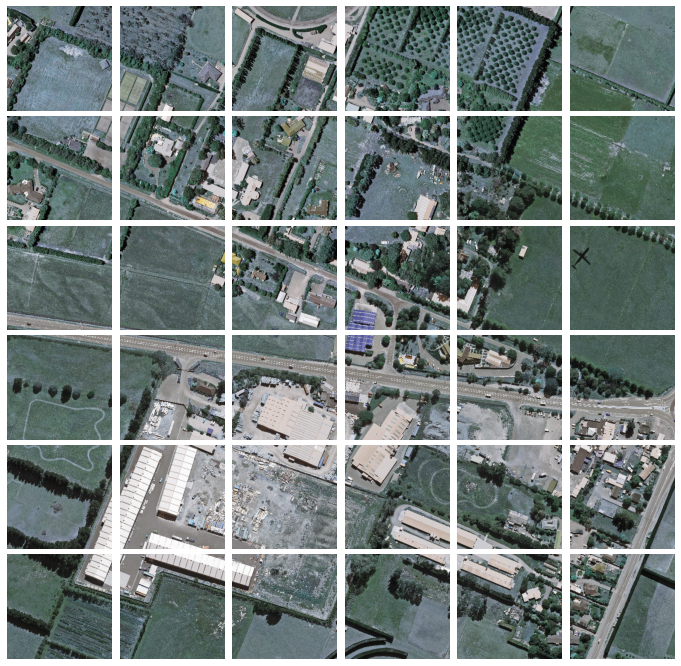

In [ ]:
for i in range(len(image_list)):
  image_filename = image_list[i]
  x = cv2.imread('/content/drive/MyDrive/airs-minisample/patch/' + image_filename)
  x = cv2.resize(x, (1536, 1536), interpolation = cv2.INTER_CUBIC)
  x = np.array(x)
  x_crops = get_patches( img_arr=x, size = 256, stride = 256)
  print("For {0}, x shape: {1}, x-crops shape: {2}".format(image_filename, x.shape, x_crops.shape))
  filename = image_filename.split('.')
  plot_patches(img_arr = x_crops, org_img_size = (1536, 1536), name = '/content/drive/MyDrive/airs-minisample/mod-test/images/'+ filename[0]+'-', stride = 256) 

For christchurch_168_vis.tif, x shape: (1536, 1536, 3), x-crops shape: (36, 256, 256, 3)


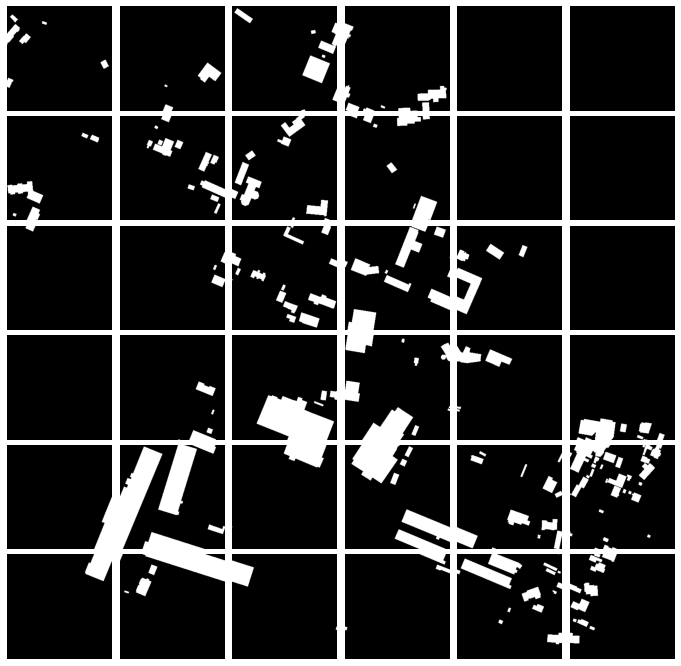

In [ ]:
for i in range(len(image_gt_list)):
  image_filename = image_gt_list[i]
  x = cv2.imread('/content/drive/MyDrive/airs-minisample/patch/' + image_filename)
  x = cv2.resize(x, (1536, 1536), interpolation = cv2.INTER_CUBIC)
  x = np.array(x)
  x_crops = get_patches( img_arr=x, size = 256, stride = 256)
  print("For {0}, x shape: {1}, x-crops shape: {2}".format(image_filename, x.shape, x_crops.shape))
  filename = image_filename.split('.')
  plot_patches(img_arr = x_crops, org_img_size = (1536, 1536), name = '/content/drive/MyDrive/airs-minisample/mod-test/masks/'+ filename[0]+'-', stride = 256) 

### **MultiRes building detection**

In [ ]:
test_image_paths_list = []
test_gt_paths_list = []
test_image_path = '/content/drive/MyDrive/airs-minisample/mod-test/images/'
test_label_path = '/content/drive/MyDrive/airs-minisample/mod-test/masks/'

for img_path in glob.glob(os.path.join(test_image_path, '*.png')):
    test_image_paths_list.append(str(img_path))        
print("Total aerial images in test set : ",len(test_image_paths_list))

for img_path in glob.glob(os.path.join(test_label_path, '*.png')):
    test_gt_paths_list.append(str(img_path))        
print("Total segmented mask images in test set : ",len(test_gt_paths_list))

test_image_paths_list.sort()
test_gt_paths_list.sort()

Total aerial images in test set :  36
Total segmented mask images in test set :  36


In [ ]:
test_X = []
test_Y = []
for img in test_image_paths_list:
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    test_X.append(img)
    
for img in test_gt_paths_list:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    test_Y.append(img)
    
print(len(test_X), len(test_Y))

36 36


In [ ]:
test_X = np.array(test_X)
test_Y = np.array(test_Y)

test_Y = test_Y.reshape((test_Y.shape[0], test_Y.shape[1], test_Y.shape[2],1))

test_X = scaler.fit_transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
test_Y = scaler.fit_transform(test_Y.reshape(-1, test_Y.shape[-1])).reshape(test_Y.shape)
# val_X = val_X / 255.
# val_Y = val_Y / 255.

print(test_X.shape)
print(test_Y.shape)

(36, 256, 256, 3)
(36, 256, 256, 1)


In [ ]:
def IOU(y_true, y_pred):
  smooth = 1.0
  # y_true = y_true.astype('float32')
  # y_pred = y_pred.astype('float32')
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  y_true_f = K.round(K.flatten(y_true))
  y_pred_f = K.round(K.flatten(y_pred))
  intersection = K.sum(y_true_f * y_pred_f)
  union = K.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)
  # jacc = intersection / (union + K.epsilon())
  jacc = (intersection + smooth) / (union + smooth)
  return jacc

def dice_coef(y_true, y_pred):
    smooth = 1.0
    # y_true = y_true.astype('float32')
    # y_pred = y_pred.astype('float32')
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = K.round(K.flatten(y_true))
    y_pred_f = K.round(K.flatten(y_pred))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mcc(y_true, y_pred):
  smooth = 1.0
  # y_true = y_true.astype('float32')
  # y_pred = y_pred.astype('float32')
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  y_true_f = K.round(K.flatten(y_true))
  y_pred_f = K.round(K.flatten(y_pred))
  tp = K.sum(y_true_f * y_pred_f)
  tn = K.sum((1-y_true_f) * (1-y_pred_f))
  fp = K.sum((1-y_true_f)*y_pred_f)
  fn = K.sum(y_true_f * (1-y_pred_f))
  up = tp*tn - fp*fn
  down = K.sqrt((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn))
  mcc = (up + smooth) / (down + smooth)
  return mcc

In [ ]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):

    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnetBP(height, width, n_channels):

    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32*2, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*4, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*8, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*16, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    
    MultiResModel = Model(inputs=[inputs], outputs=[conv10])

    return MultiResModel

In [ ]:
MultiResModel_test = MultiResUnetBP(height=256, width=256, n_channels=3)
MultiResModel_test.load_weights('/content/drive/MyDrive/airs-minisample/weights/multires-resize-1500images-bp-100epochs.tf')

Image number: 0
IOU Score: 0.9178155064582825 
Dice Coefficent: 0.9571349620819092 
MCC: 0.9559181928634644


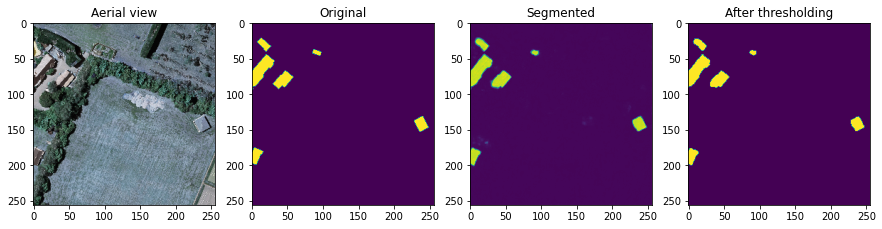

Image number: 1
IOU Score: 0.9445359706878662 
Dice Coefficent: 0.9714689254760742 
MCC: 0.9707930088043213


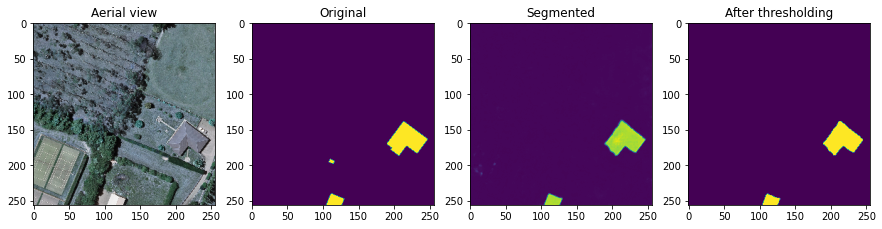

Image number: 2
IOU Score: 1.0 
Dice Coefficent: 1.0 
MCC: 1.0


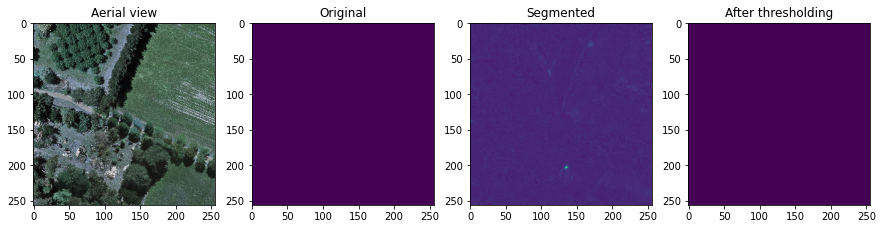

Image number: 3
IOU Score: 1.0 
Dice Coefficent: 1.0 
MCC: 1.0


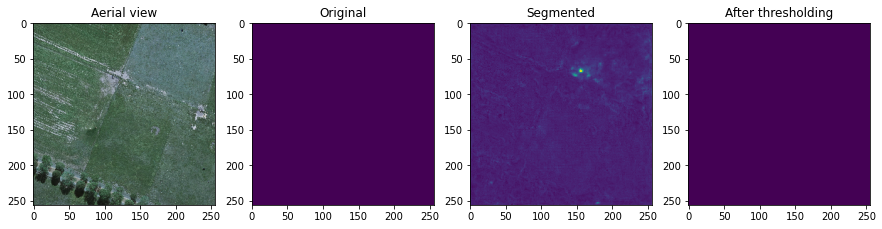

Image number: 4
IOU Score: 0.9301470518112183 
Dice Coefficent: 0.9637404680252075 
MCC: 0.9636694192886353


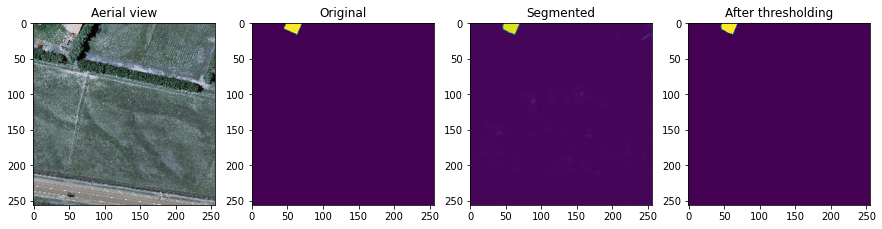

Image number: 5
IOU Score: 0.9404352903366089 
Dice Coefficent: 0.9692853093147278 
MCC: 0.9688825607299805


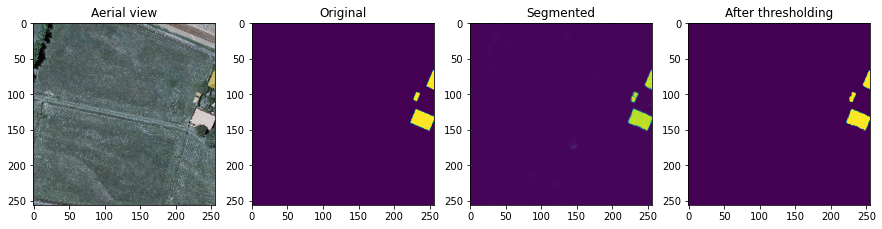

Image number: 6
IOU Score: 0.9236165285110474 
Dice Coefficent: 0.9602885246276855 
MCC: 0.9563769698143005


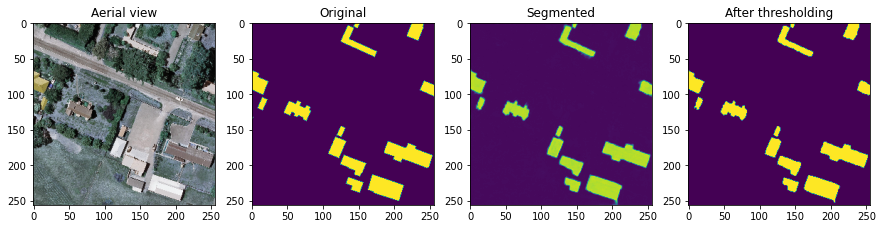

Image number: 7
IOU Score: 0.9437322020530701 
Dice Coefficent: 0.9710503220558167 
MCC: 0.9654420614242554


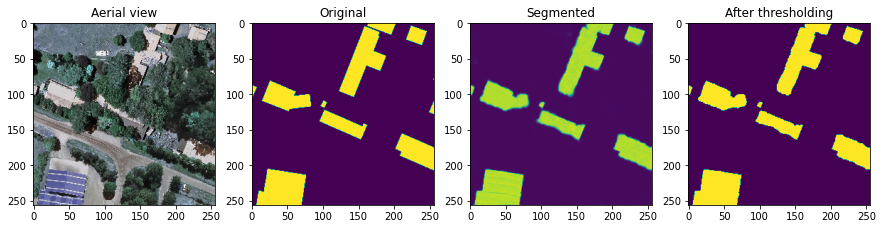

Image number: 8
IOU Score: 0.9420487880706787 
Dice Coefficent: 0.970156729221344 
MCC: 0.9677413105964661


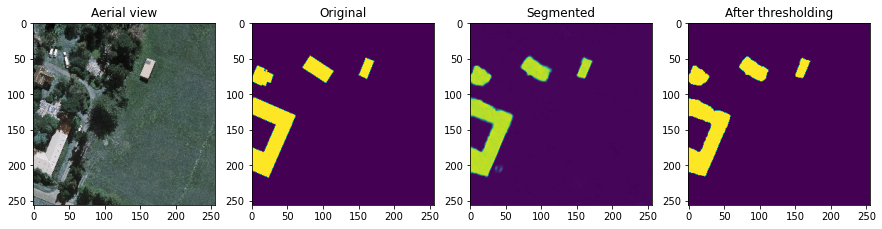

Image number: 9
IOU Score: 1.0 
Dice Coefficent: 1.0 
MCC: 1.0


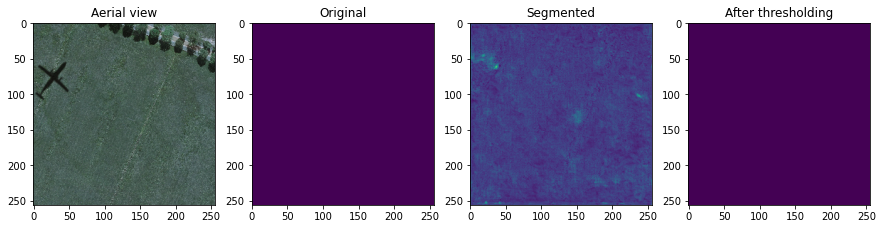

Image number: 10
IOU Score: 1.0 
Dice Coefficent: 1.0 
MCC: 1.0


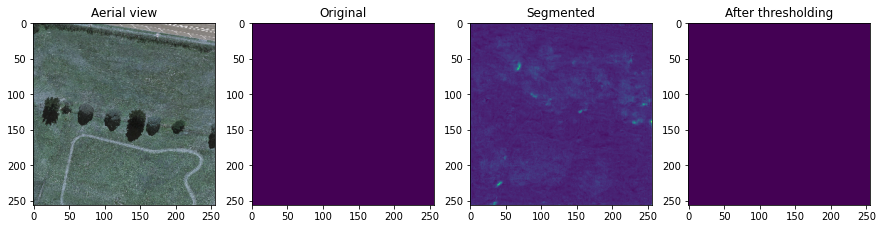

Image number: 11
IOU Score: 0.9502053260803223 
Dice Coefficent: 0.974460244178772 
MCC: 0.9737639427185059


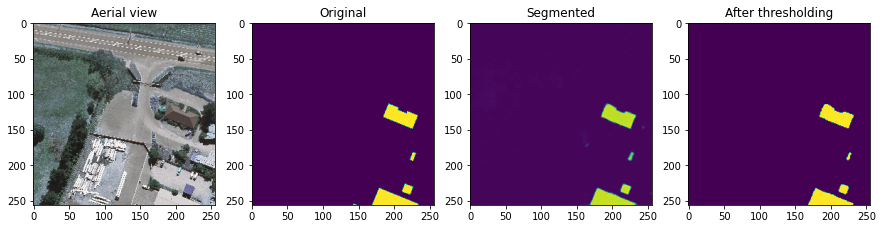

Image number: 12
IOU Score: 0.9577436447143555 
Dice Coefficent: 0.9784135818481445 
MCC: 0.9766644835472107


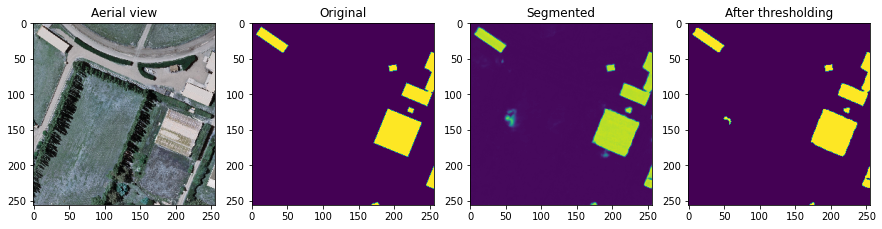

Image number: 13
IOU Score: 0.9800114035606384 
Dice Coefficent: 0.9899044632911682 
MCC: 0.98722243309021


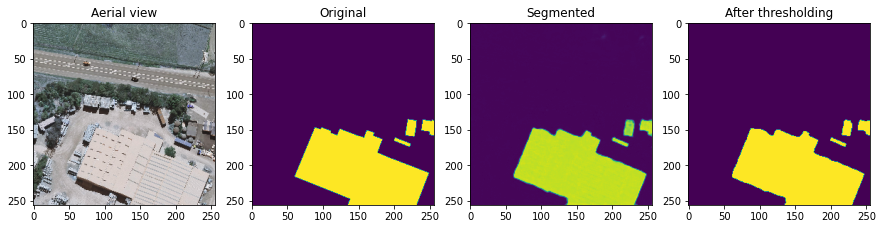

Image number: 14
IOU Score: 0.9701955914497375 
Dice Coefficent: 0.9848716259002686 
MCC: 0.9820564985275269


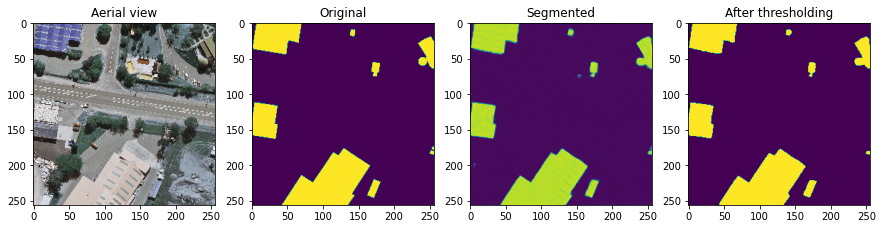

Image number: 15
IOU Score: 0.9512419700622559 
Dice Coefficent: 0.9750078320503235 
MCC: 0.9737327694892883


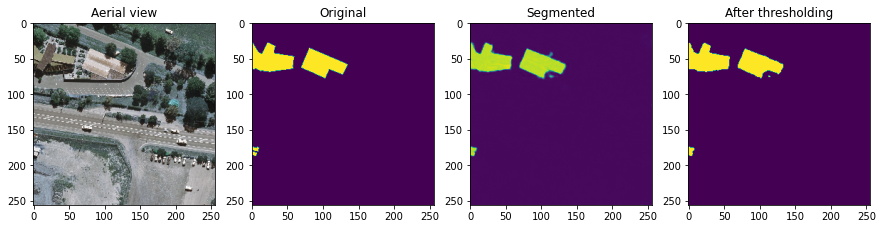

Image number: 16
IOU Score: 0.9587282538414001 
Dice Coefficent: 0.9789271950721741 
MCC: 0.9772619605064392


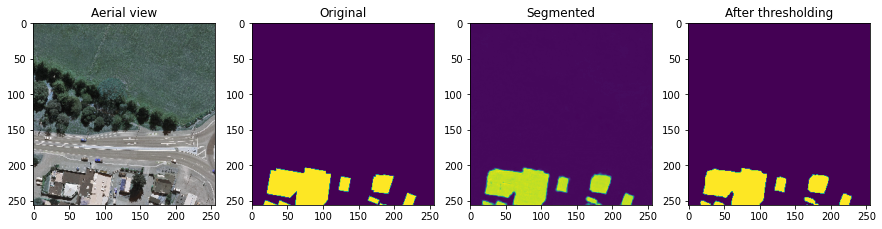

Image number: 17
IOU Score: 0.9648328423500061 
Dice Coefficent: 0.9820985198020935 
MCC: 0.9813339710235596


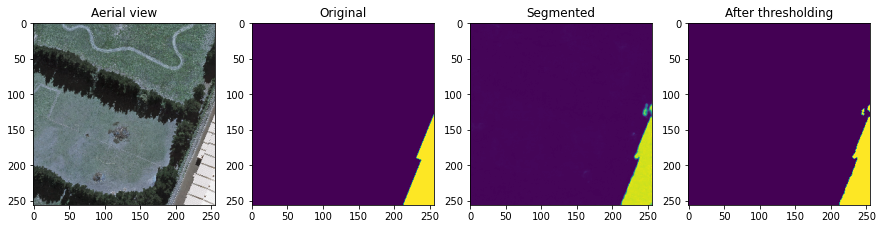

Image number: 18
IOU Score: 0.9778180718421936 
Dice Coefficent: 0.9887843728065491 
MCC: 0.9827994108200073


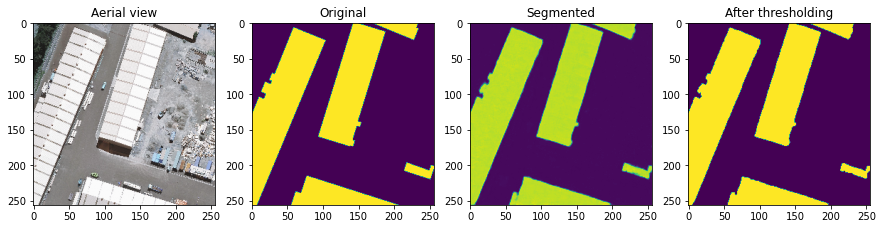

Image number: 19
IOU Score: 0.9730814695358276 
Dice Coefficent: 0.9863554835319519 
MCC: 0.9854274988174438


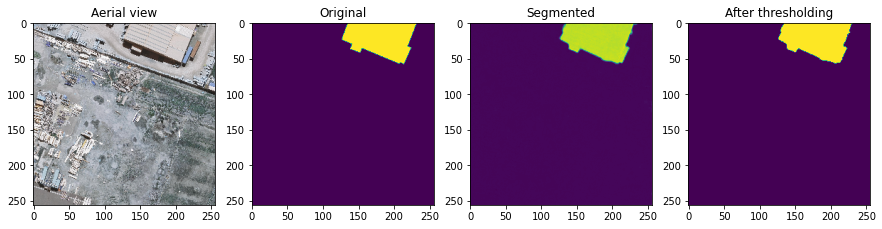

Image number: 20
IOU Score: 0.9783675074577332 
Dice Coefficent: 0.9890651106834412 
MCC: 0.98591548204422


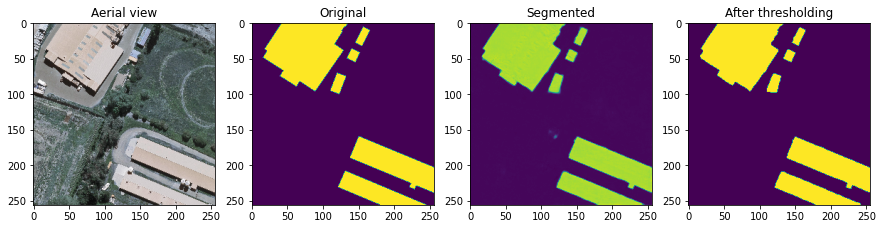

Image number: 21
IOU Score: 0.9144911766052246 
Dice Coefficent: 0.955332338809967 
MCC: 0.9511518478393555


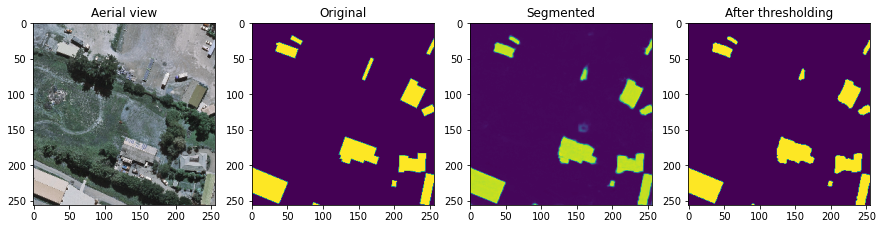

Image number: 22
IOU Score: 0.9277677536010742 
Dice Coefficent: 0.962528645992279 
MCC: 0.9562448859214783


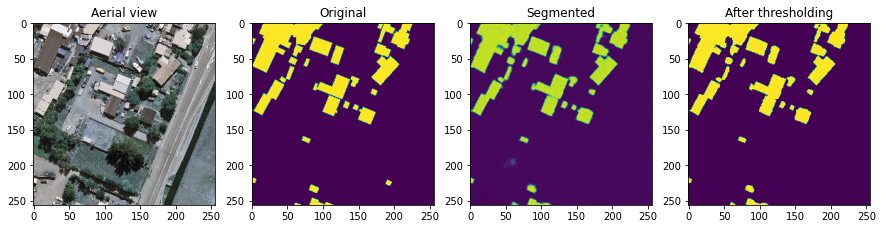

Image number: 23
IOU Score: 0.953682005405426 
Dice Coefficent: 0.9762887954711914 
MCC: 0.9748985171318054


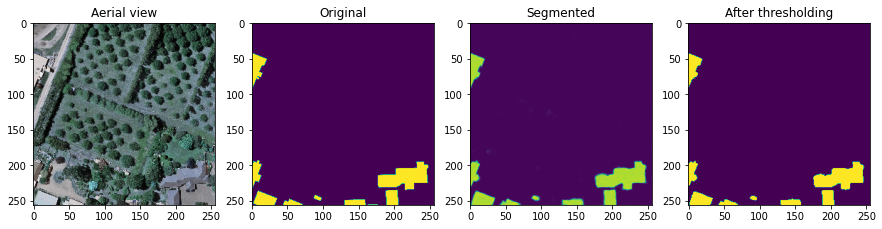

Image number: 24
IOU Score: 0.9842228889465332 
Dice Coefficent: 0.9920473694801331 
MCC: 0.9916713237762451


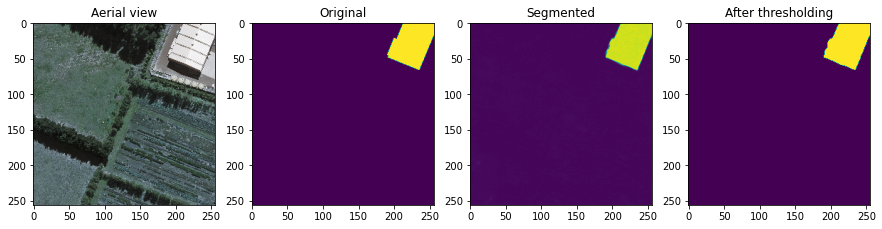

Image number: 25
IOU Score: 0.9784828424453735 
Dice Coefficent: 0.9891237616539001 
MCC: 0.9875972270965576


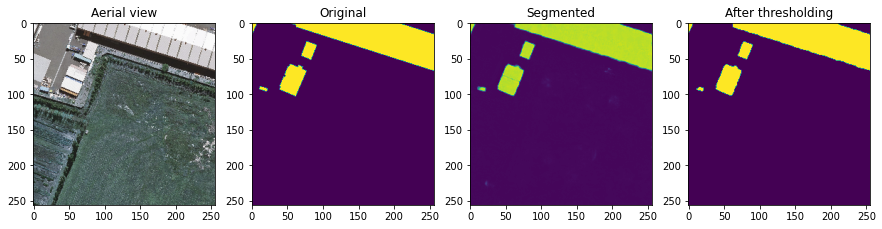

Image number: 26
IOU Score: 0.966803252696991 
Dice Coefficent: 0.983117938041687 
MCC: 0.9824740290641785


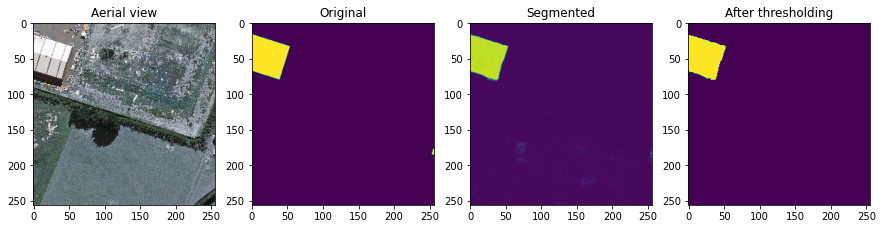

Image number: 27
IOU Score: 0.9520661234855652 
Dice Coefficent: 0.9754341244697571 
MCC: 0.9750025272369385


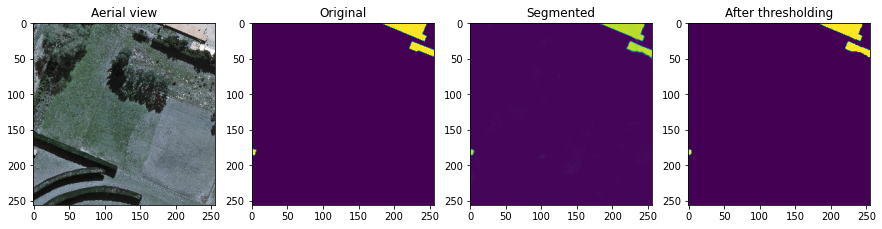

Image number: 28
IOU Score: 0.9583670496940613 
Dice Coefficent: 0.9787397384643555 
MCC: 0.9756191372871399


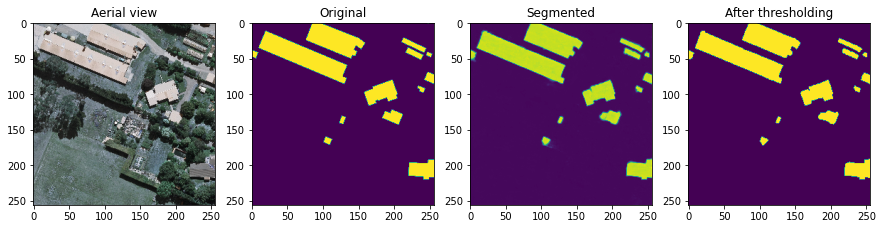

Image number: 29
IOU Score: 0.9405764937400818 
Dice Coefficent: 0.96937495470047 
MCC: 0.9671932458877563


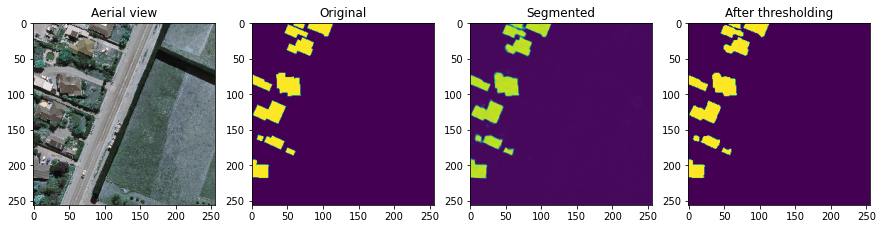

Image number: 30
IOU Score: 1.0 
Dice Coefficent: 1.0 
MCC: 1.0


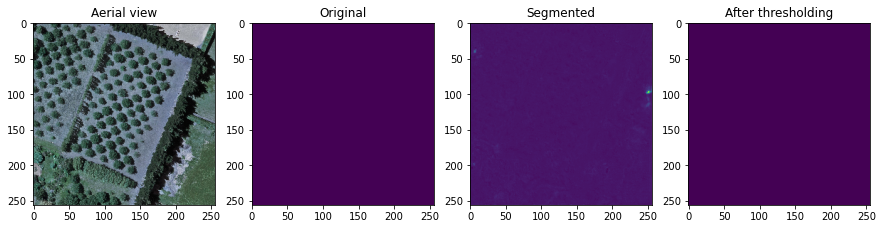

Image number: 31
IOU Score: 1.0 
Dice Coefficent: 1.0 
MCC: 1.0


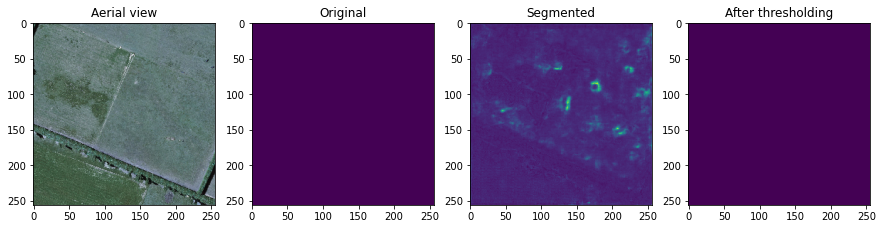

Image number: 32
IOU Score: 0.9482338428497314 
Dice Coefficent: 0.973425030708313 
MCC: 0.9721786975860596


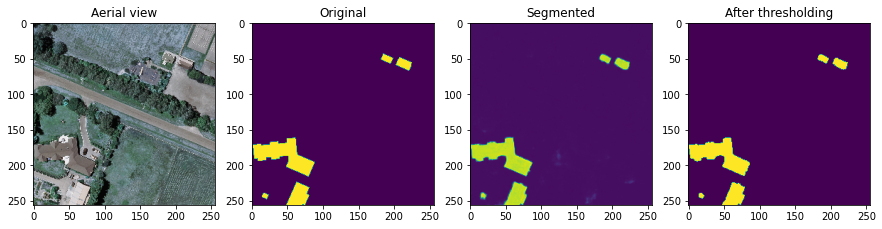

Image number: 33
IOU Score: 0.9262151122093201 
Dice Coefficent: 0.9616904854774475 
MCC: 0.9586485624313354


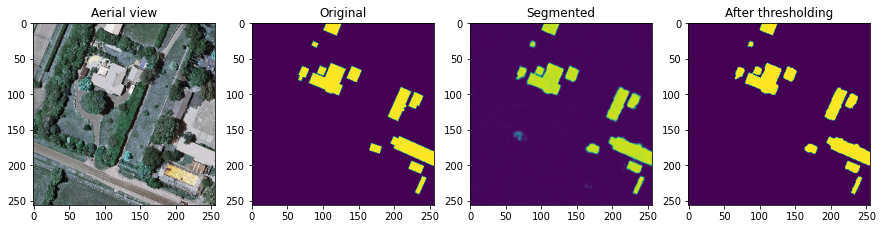

Image number: 34
IOU Score: 0.9503732919692993 
Dice Coefficent: 0.9745533466339111 
MCC: 0.971716046333313


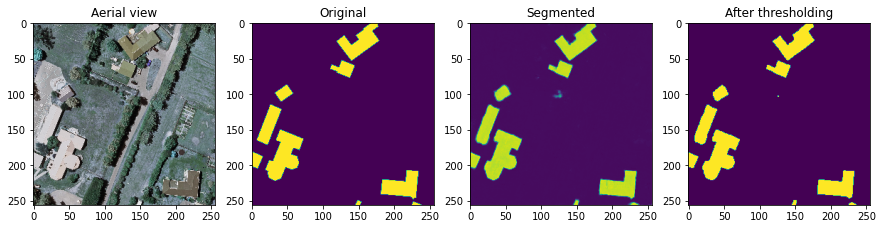

Image number: 35
IOU Score: 0.8903213143348694 
Dice Coefficent: 0.9419727325439453 
MCC: 0.9376969337463379


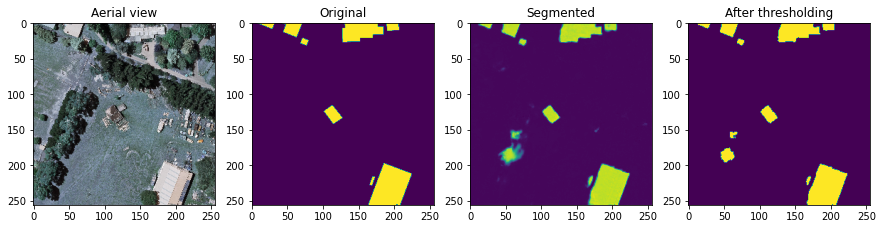

In [ ]:
rows = 36
columns = 4
count = 1
x_crops_pred = []
x_crops_actual = []
for image_number in range(0, 36):

  fig = plt.figure(figsize=(15,15))
  print('Image number: {0}'.format(image_number))
  pred_y = MultiResModel_test.predict(test_X[image_number:image_number+1])
  pred_y_thresholded = (pred_y[0,:,:,0]>0.5)

  fig.add_subplot(rows, columns, count)
  plt.subplot(1,4,1)
  plt.imshow(np.squeeze(test_X[image_number:image_number+1]))
  plt.title('Aerial view')

  fig.add_subplot(rows, columns, count+1)
  plt.subplot(1,4,2)
  plt.imshow(np.squeeze(test_Y[image_number:image_number+1]))
  plt.title('Original')

  fig.add_subplot(rows, columns, count+2)
  plt.subplot(1,4,3)
  plt.imshow(np.squeeze(pred_y[0]))
  plt.title('Segmented')

  fig.add_subplot(rows, columns, count+3)
  plt.subplot(1,4,4)
  plt.imshow(np.squeeze(pred_y_thresholded))
  plt.title('After thresholding')
  count += 4

  x_crops_pred.append(pred_y_thresholded)
  x_crops_actual.append(test_Y[image_number:image_number+1][0])

  print("IOU Score: {0} \nDice Coefficent: {1} \nMCC: {2}".format(IOU(test_Y[image_number:image_number+1], pred_y), dice_coef(test_Y[image_number:image_number+1], pred_y), mcc(test_Y[image_number:image_number+1], pred_y)))

  plt.show()

### **Image patching**

In [ ]:
def reconstruct_from_patches(img_arr, org_img_size, stride=None, size=None):
    """[summary]
    
    Args:
        img_arr (numpy.ndarray): [description]
        org_img_size (tuple): [description]
        stride ([type], optional): [description]. Defaults to None.
        size ([type], optional): [description]. Defaults to None.
    
    Raises:
        ValueError: [description]
    
    Returns:
        numpy.ndarray: [description]
    """
    # check parameters
    if type(org_img_size) is not tuple:
        raise ValueError("org_image_size must be a tuple")

    if img_arr.ndim == 3:
        img_arr = np.expand_dims(img_arr, axis=0)

    if size is None:
        size = img_arr.shape[1]

    if stride is None:
        stride = size

    nm_layers = img_arr.shape[3]

    i_max = (org_img_size[0] // stride) + 1 - (size // stride)
    j_max = (org_img_size[1] // stride) + 1 - (size // stride)

    total_nm_images = img_arr.shape[0] // (i_max ** 2)
    nm_images = img_arr.shape[0]

    averaging_value = size // stride
    images_list = []
    kk = 0
    for img_count in range(total_nm_images):
        img_bg = np.zeros(
            (org_img_size[0], org_img_size[1], nm_layers), dtype=img_arr[0].dtype
        )

        for i in range(i_max):
            for j in range(j_max):
                for layer in range(nm_layers):
                    img_bg[
                        i * stride : i * stride + size,
                        j * stride : j * stride + size,
                        layer,
                    ] = img_arr[kk, :, :, layer]

                kk += 1
        # TODO add averaging for masks - right now it's just overwritting

        #         for layer in range(nm_layers):
        #             # average some more because overlapping 4 patches
        #             img_bg[stride:i_max*stride, stride:i_max*stride, layer] //= averaging_value
        #             # corners:
        #             img_bg[0:stride, 0:stride, layer] *= averaging_value
        #             img_bg[i_max*stride:i_max*stride+stride, 0:stride, layer] *= averaging_value
        #             img_bg[i_max*stride:i_max*stride+stride, i_max*stride:i_max*stride+stride, layer] *= averaging_value
        #             img_bg[0:stride, i_max*stride:i_max*stride+stride, layer] *= averaging_value

        images_list.append(img_bg)

    return np.stack(images_list)


In [ ]:
x_crops_pred = np.stack(x_crops_pred)
x_crops_actual = np.stack(x_crops_actual)
print(x_crops_pred.shape, type(x_crops_pred), x_crops_actual.shape)

x_crops_pred_2 = np.reshape(x_crops_pred, x_crops_pred.shape + (1,))
x_crops_actual_2 = x_crops_actual
# x_crops_actual_2 = np.reshape(x_crops_actual, x_crops_actual.shape + (1,))
print(x_crops_pred_2.shape, x_crops_actual_2.shape)

(36, 256, 256) <class 'numpy.ndarray'> (36, 256, 256, 1)
(36, 256, 256, 1) (36, 256, 256, 1)


x_crops shape:  (36, 256, 256, 1)
x_reconstructed shape:  (1, 1536, 1536, 1)
x_reconstructed shape:  (1, 1536, 1536, 1)


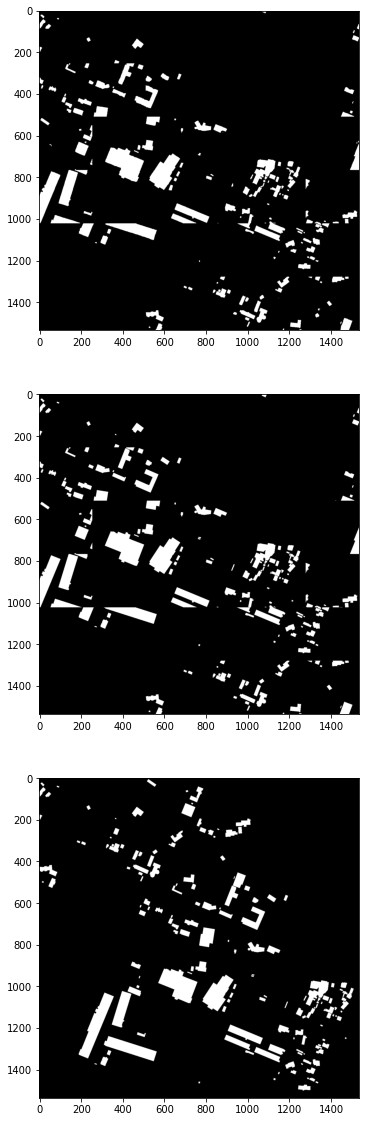

In [ ]:
print("x_crops shape: ", str(x_crops_pred_2.shape))

x_reconstructed_pred = reconstruct_from_patches(
    img_arr=x_crops_pred_2, # required - array of cropped out images
    org_img_size=(1536, 1536), # required - original size of the image
    stride=256) # use only if stride is different from patch size

print("x_reconstructed shape: ", str(x_reconstructed_pred.shape))

x_reconstructed_actual = reconstruct_from_patches(
    img_arr=x_crops_actual_2, # required - array of cropped out images
    org_img_size=(1536, 1536), # required - original size of the image
    stride=256) # use only if stride is different from patch size

print("x_reconstructed shape: ", str(x_reconstructed_actual.shape))

x_orig = cv2.imread('/content/drive/MyDrive/airs-minisample/patch/' + image_gt_list[0])
x_orig = cv2.resize(x_orig, (1536, 1536), interpolation = cv2.INTER_CUBIC)

fig = plt.figure(figsize=(20,20))

fig.add_subplot(3,1,1)
# plt.subplot(1,2,1)
plt.imshow(np.squeeze(x_reconstructed_pred[0]), cmap = 'gray')
# plt.show()

fig.add_subplot(3,1,2)
# plt.subplot(1,2,2)
plt.imshow(np.squeeze(x_reconstructed_actual[0]), cmap = 'gray')
# plt.show()

fig.add_subplot(3,1,3)
# plt.subplot(1,2,2)
plt.imshow(np.squeeze(x_orig), cmap = 'gray')

### **Roof Extraction**

In [ ]:
def draw_bb_color_filling(img, img_mask):

  # convert to grayscale
  gray = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)

  # threshold
  thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)[1]

  # get contours
  result = img_mask.copy()
  seg_with_bounded_box = img_mask.copy()
  contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = contours[0] if len(contours) == 2 else contours[1]
  print("No of identified buildings: {0}".format(len(contours)))
  bb = []

  for cntr in contours:
      x,y,w,h = cv2.boundingRect(cntr)
      cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 0), 1)
      cv2.rectangle(seg_with_bounded_box, (x, y), (x+w, y+h), (255, 255, 255), -1)
      bb.append([x,y,w,h])

  print(bb)   

  plt.imshow(seg_with_bounded_box)
  plt.title('Segmented mask with bounding box and color filling')
  plt.show()

  plt.imshow(result)
  plt.title('Segmented mask with bounding box')
  plt.show()

  return bb, seg_with_bounded_box, result

In [ ]:
# Post-process
def background_subtraction(img, seg_with_bounded_box):
  
  new_seg_image_gray = cv2.cvtColor(seg_with_bounded_box, cv2.COLOR_RGB2GRAY) # Convert the mask to grayscale
  img_np = np.asarray(img) # Convert the PIL image to a numpy array
  masked_out = cv2.bitwise_and(img_np, img_np, mask = new_seg_image_gray) # Blend the mask
  masked_out_new = np.where(masked_out != 0, masked_out, 255) # Remove the background
  
  plt.imshow(masked_out_new)
  plt.title('Masked-out Image')
  plt.show()
  
  return masked_out_new

In [ ]:
def crop_and_save(bb, masked_out_new, building_name):

  for i in range(len(bb)):
    x = bb[i][0]
    y = bb[i][1]
    w = bb[i][2]
    h = bb[i][3]
    cv2.imwrite('/content/drive/MyDrive/airs-minisample/mod-test/buildings/'+ building_name + '_' + str(i) + '.tif', masked_out_new[y:y+h, x:x+w])

christchurch_168
(10000, 10000, 3) (10000, 10000, 3) <class 'numpy.ndarray'>
No of identified buildings: 160
[[8098, 9581, 389, 187], [4979, 9483, 60, 64], [8640, 9472, 92, 76], [7319, 9372, 82, 77], [8445, 9364, 187, 128], [8375, 9355, 67, 63], [7466, 9182, 59, 78], [7859, 9125, 191, 140], [8341, 9042, 304, 215], [1732, 8912, 79, 49], [8181, 8906, 72, 67], [7691, 8852, 309, 239], [8555, 8788, 225, 215], [8244, 8779, 275, 179], [1918, 8707, 250, 297], [8260, 8597, 57, 50], [8073, 8557, 162, 113], [6438, 8501, 286, 155], [2117, 8499, 145, 171], [8034, 8466, 228, 139], [8650, 8465, 252, 171], [6725, 8404, 814, 487], [8630, 8346, 219, 125], [8711, 8309, 108, 80], [7158, 8307, 546, 352], [8839, 8264, 240, 196], [8852, 8143, 98, 85], [7943, 8106, 51, 63], [9553, 8099, 63, 62], [2024, 8063, 1658, 789], [8204, 8041, 169, 298], [5787, 8019, 815, 482], [3058, 7943, 282, 155], [8009, 7855, 252, 183], [7462, 7707, 368, 256], [5896, 7703, 1101, 621], [8787, 7701, 85, 68], [9302, 7434, 165, 164], [

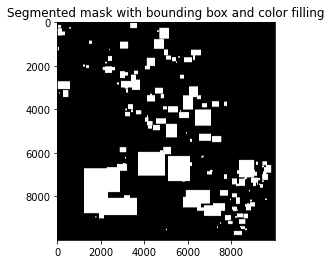

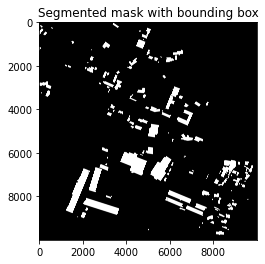

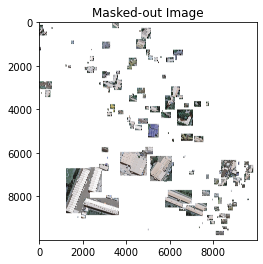

In [ ]:
for i in range(len(image_list)):
  building_name = image_list[i].split('.')
  img = cv2.imread('/content/drive/MyDrive/airs-minisample/patch/' + image_list[i], cv2.IMREAD_COLOR)
  img_mask = cv2.imread('/content/drive/MyDrive/airs-minisample/patch/' + image_gt_list[i], cv2.IMREAD_COLOR)
  print(img.shape, img_mask.shape, type(img_mask))

  bb, seg_with_bounded_box, result = draw_bb_color_filling(img, img_mask)
  masked_out_new = background_subtraction(img, seg_with_bounded_box)
  crop_and_save(bb, masked_out_new, building_name[0])